# exp046_ea
exp046の誤差分析

In [31]:
# import library
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn2_circles
import seaborn as sns
from tqdm.notebook import tqdm
import pathlib
import plotly
import plotly.express as px
import itertools
import lightgbm as lgb
from optuna.integration import lightgbm as optuna_lgb
import simdkalman
import optuna
import pyproj
from pyproj import Proj, transform
from sklearn import metrics
from sklearn.metrics import roc_curve
pd.set_option('display.max_rows', 100)

In [32]:
import ipynb_path

def get_nb_name():
    nb_path = ipynb_path.get()
    nb_name = nb_path.rsplit('/',1)[1].replace('.ipynb','')
    return nb_name

In [33]:
# directory setting
nb_name = get_nb_name()
INPUT = '../input/google-smartphone-decimeter-challenge'
OUTPUT = '../output/' + nb_name
os.makedirs(OUTPUT, exist_ok=True)

# utils

In [34]:
def get_train_score(df, gt):
    gt = gt.rename(columns={'latDeg':'latDeg_gt', 'lngDeg':'lngDeg_gt'})
    df = df.merge(gt, on=['collectionName', 'phoneName', 'millisSinceGpsEpoch'], how='inner')
    # calc_distance_error
    df['err'] = calc_haversine(df['latDeg_gt'], df['lngDeg_gt'], df['latDeg'], df['lngDeg'])
    # calc_evaluate_score
    df['phone'] = df['collectionName'] + '_' + df['phoneName']
    res = df.groupby('phone')['err'].agg([percentile50, percentile95])
    res['p50_p90_mean'] = (res['percentile50'] + res['percentile95']) / 2 
    score = res['p50_p90_mean'].mean()
    return score

In [35]:
def calc_haversine(lat1, lon1, lat2, lon2):
    """Calculates the great circle distance between two points
    on the earth. Inputs are array-like and specified in decimal degrees.
    """
    RADIUS = 6_367_000
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    dist = 2 * RADIUS * np.arcsin(a**0.5)
    return dist

In [36]:
def visualize_trafic(df, center, zoom=9):
    fig = px.scatter_mapbox(df,
                            
                            # Here, plotly gets, (x,y) coordinates
                            lat="latDeg",
                            lon="lngDeg",
                            
                            #Here, plotly detects color of series
                            color="phoneName",
                            labels="phoneName",
                            
                            zoom=zoom,
                            center=center,
                            height=600,
                            width=800)
    fig.update_layout(mapbox_style='stamen-terrain')
    fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
    fig.update_layout(title_text="GPS trafic")
    fig.show()
    
def visualize_collection(df, collection):
    target_df = df[df['collectionName']==collection].copy()
    lat_center = target_df['latDeg'].mean()
    lng_center = target_df['lngDeg'].mean()
    center = {"lat":lat_center, "lon":lng_center}
    
    visualize_trafic(target_df, center)

In [37]:
# ground_truth
def get_ground_truth():
    p = pathlib.Path(INPUT)
    gt_files = list(p.glob('train/*/*/ground_truth.csv'))

    gts = []
    for gt_file in gt_files:
        gts.append(pd.read_csv(gt_file))
    ground_truth = pd.concat(gts)

    return ground_truth

In [38]:
def percentile50(x):
    return np.percentile(x, 50)
def percentile95(x):
    return np.percentile(x, 95)

In [39]:
class train_result:
    def __init__(self, df):
        self.df = df
        self.gt = get_ground_truth()
        self.bl = pd.read_csv(INPUT + '/' + 'baseline_locations_train.csv')
        
        self.gt = self.gt.rename(columns={'latDeg':'latDeg_gt', 'lngDeg':'lngDeg_gt'})
        self.df = self.df.merge(self.gt, on=['collectionName', 'phoneName', 'millisSinceGpsEpoch'], how='inner')
        self.df['phone'] = self.df['collectionName'] + '_' + self.df['phoneName']
        self.df['err'] =  calc_haversine(self.df['latDeg_gt'], self.df['lngDeg_gt'], self.df['latDeg'], self.df['lngDeg'])
        
        self.phone_res = self.calc_err('phone')
        self.clc_res = self.calc_err('collectionName')
        self.phonename_res = self.calc_err('phoneName')
        
    def calc_err(self, by):
        res = self.df.groupby(by)['err'].agg([percentile50, percentile95])
        res['p50_p90_mean'] = (res['percentile50'] + res['percentile95']) / 2
        return res
    
    @property
    def score(self):
        return self.phone_res['p50_p90_mean'].mean()
    @property
    def raw_data(self):
        return self.df
    @property
    def err(self):
        return self.phone_res
    @property
    def collection_err(self):
        return self.clc_res
    @property
    def phonename_err(self):
        return self.phonename_res
    
    def viz_map(self, collection, show_gt=True, show_bl=True):
        tmp = self.df[self.df['collectionName']==collection][['collectionName', 'phoneName', 'latDeg', 'lngDeg']]
        tmp2 = self.df[self.df['collectionName']==collection][['collectionName', 'phoneName', 'latDeg_gt', 'lngDeg_gt']]
        tmp2 = tmp2.rename(columns={'latDeg_gt':'latDeg', 'lngDeg_gt':'lngDeg'})
        tmp2['phoneName'] = tmp2['phoneName'] + '_GT'
        tmp3 = self.bl[self.bl['collectionName']==collection][['collectionName', 'phoneName', 'latDeg', 'lngDeg']]
        tmp3['phoneName'] = tmp3['phoneName'] + '_BL'
        
        if show_gt:
            tmp = tmp.append(tmp2)
        if show_bl:
            tmp = tmp.append(tmp3)
        visualize_collection(tmp, collection)

In [40]:
def get_data():
    base_train = pd.read_csv(INPUT + '/' + 'baseline_locations_train.csv')
    base_test = pd.read_csv(INPUT + '/' + 'baseline_locations_test.csv')
    sample_sub = pd.read_csv(INPUT + '/' + 'sample_submission.csv')
    ground_truth = get_ground_truth()
    return base_train, base_test, sample_sub, ground_truth

In [46]:
train_pred = pd.read_csv('../output/exp046/train_rog_df.csv')

In [47]:
train, test, _, gt = get_data()

In [48]:
gt = gt.reset_index(drop=True)

In [49]:
train_pred

,collectionName,phoneName,millisSinceGpsEpoch,latDeg,lngDeg,heightAboveWgs84EllipsoidM,phone,dist_pred,latDeg_gt,lngDeg_gt,...,dist_next,deg_pred_prev,deg_pred_next,dist_pred_prev,dist_pred_next,g,lat_forward,lng_forward,lat_reversed,lng_reversed
0,2021-03-10-US-SVL-1,Pixel4XL,1299453168638,NaN,NaN,24.93,2021-03-10-US-SVL-1_Pixel4XL,NaN,37.371314,-122.047980,...,6.536023,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN
1,2021-03-10-US-SVL-1,Pixel4XL,1299453169651,37.371295,-122.048026,6.56,2021-03-10-US-SVL-1_Pixel4XL,0.0,37.371314,-122.047980,...,9.354958,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2,2021-03-10-US-SVL-1,Pixel4XL,1299453170646,37.371211,-122.048033,19.14,2021-03-10-US-SVL-1_Pixel4XL,0.0,37.371314,-122.047980,...,9.042584,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN
3,2021-03-10-US-SVL-1,Pixel4XL,1299453171664,37.371200,-122.048134,24.47,2021-03-10-US-SVL-1_Pixel4XL,0.0,37.371314,-122.047980,...,2.853071,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN
4,2021-03-10-US-SVL-1,Pixel4XL,1299453172650,37.371194,-122.048102,21.83,2021-03-10-US-SVL-1_Pixel4XL,0.0,37.371314,-122.047980,...,2.626328,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30446,2021-04-29-US-SJC-2,SamsungS20Ultra,1303760315000,37.334460,-121.899600,-8.09,2021-04-29-US-SJC-2_SamsungS20Ultra,0.0,37.334475,-121.899613,...,2.011345,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN
30447,2021-04-29-US-SJC-2,SamsungS20Ultra,1303760316000,37.334472,-121.899583,-7.59,2021-04-29-US-SJC-2_SamsungS20Ultra,0.0,37.334475,-121.899613,...,2.447052,NaN,176.524924,0.0,0.0,NaN,NaN,NaN,NaN,NaN
30448,2021-04-29-US-SJC-2,SamsungS20Ultra,1303760317000,37.334491,-121.899597,-8.35,2021-04-29-US-SJC-2_SamsungS20Ultra,0.0,37.334475,-121.899613,...,1.303535,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN
30449,2021-04-29-US-SJC-2,SamsungS20Ultra,1303760318000,37.334495,-121.899583,-8.73,2021-04-29-US-SJC-2_SamsungS20Ultra,0.0,37.334475,-121.899613,...,1.582827,176.524924,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN


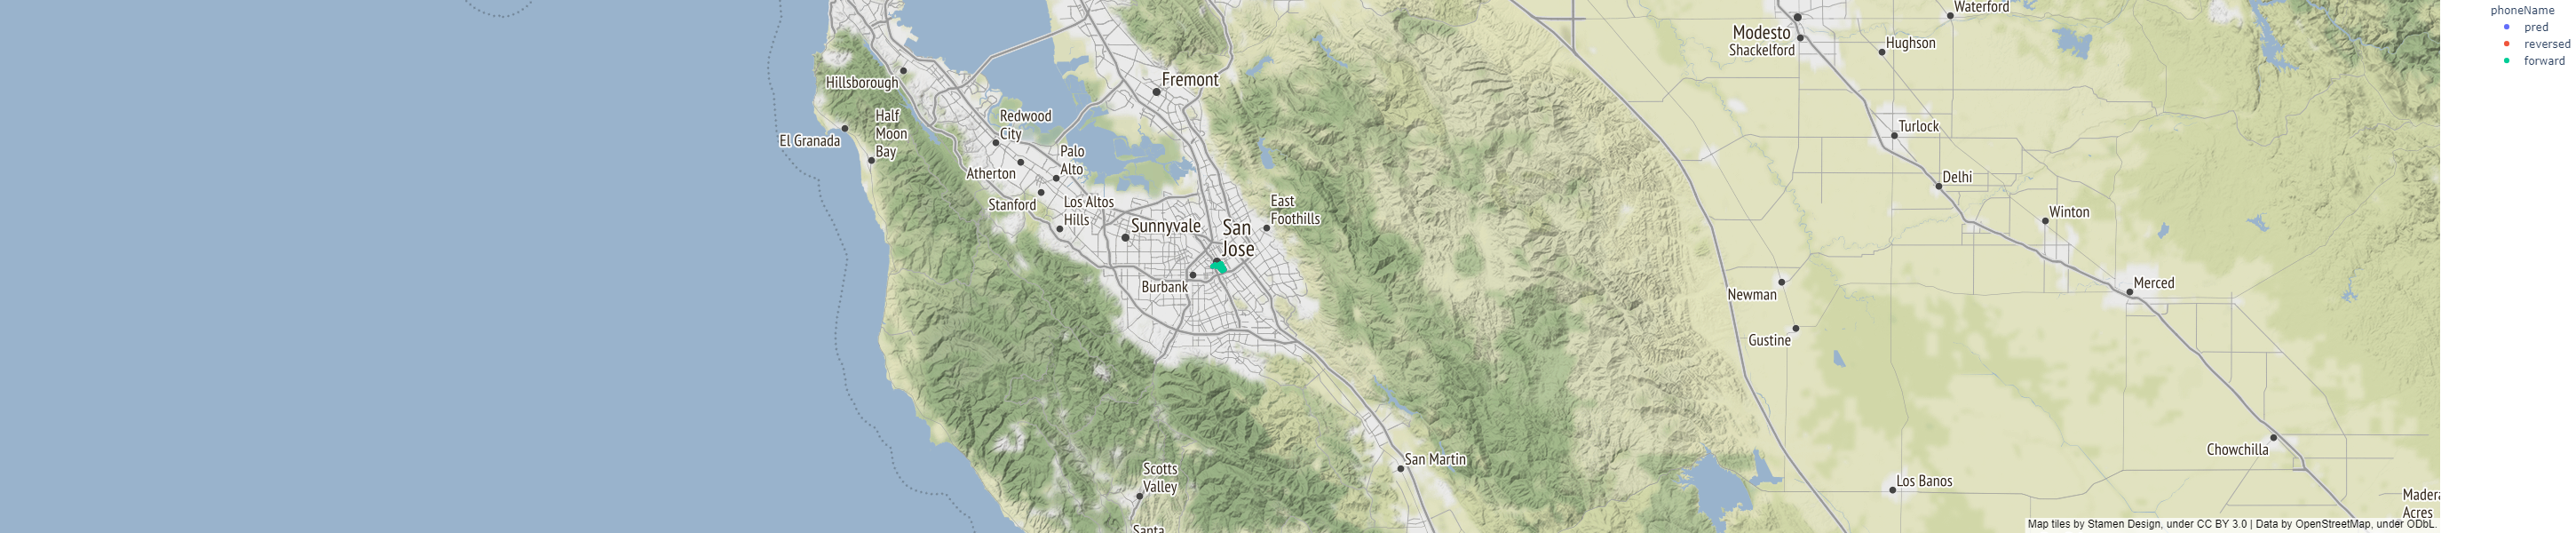

In [52]:
tmp1 = train_pred.copy()
tmp2 = train_pred[['collectionName', 'phoneName', 'phone', 'lat_reversed', 'lng_reversed']].copy()
tmp3 = train_pred[['collectionName', 'phoneName', 'phone', 'lat_forward', 'lng_forward']].copy()
tmp2.columns = ['collectionName', 'phoneName', 'phone', 'latDeg', 'lngDeg']
tmp3.columns = ['collectionName', 'phoneName', 'phone', 'latDeg', 'lngDeg']
tmp4 = gt.copy()

tmp1['phoneName'] = 'pred'
tmp2['phoneName'] = 'reversed'
tmp3['phoneName'] = 'forward'
tmp4['phoneName'] = 'gt'

#tmp = pd.concat([tmp1, tmp2, tmp3, tmp4])
tmp = pd.concat([tmp1,tmp2, tmp3])

visualize_collection(tmp, '2021-04-28-US-SJC-1')

In [51]:
tmp

,collectionName,phoneName,millisSinceGpsEpoch,latDeg,lngDeg,heightAboveWgs84EllipsoidM,phone,dist_pred,latDeg_gt,lngDeg_gt,...,dist_next,deg_pred_prev,deg_pred_next,dist_pred_prev,dist_pred_next,g,lat_forward,lng_forward,lat_reversed,lng_reversed
0,2021-03-10-US-SVL-1,pred,1.299453e+12,NaN,NaN,24.93,2021-03-10-US-SVL-1_Pixel4XL,NaN,37.371314,-122.04798,...,6.536023,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN
1,2021-03-10-US-SVL-1,pred,1.299453e+12,37.371295,-122.048026,6.56,2021-03-10-US-SVL-1_Pixel4XL,0.0,37.371314,-122.04798,...,9.354958,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2,2021-03-10-US-SVL-1,pred,1.299453e+12,37.371211,-122.048033,19.14,2021-03-10-US-SVL-1_Pixel4XL,0.0,37.371314,-122.04798,...,9.042584,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN
3,2021-03-10-US-SVL-1,pred,1.299453e+12,37.371200,-122.048134,24.47,2021-03-10-US-SVL-1_Pixel4XL,0.0,37.371314,-122.04798,...,2.853071,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN
4,2021-03-10-US-SVL-1,pred,1.299453e+12,37.371194,-122.048102,21.83,2021-03-10-US-SVL-1_Pixel4XL,0.0,37.371314,-122.04798,...,2.626328,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30446,2021-04-29-US-SJC-2,forward,NaN,NaN,NaN,NaN,2021-04-29-US-SJC-2_SamsungS20Ultra,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30447,2021-04-29-US-SJC-2,forward,NaN,NaN,NaN,NaN,2021-04-29-US-SJC-2_SamsungS20Ultra,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30448,2021-04-29-US-SJC-2,forward,NaN,NaN,NaN,NaN,2021-04-29-US-SJC-2_SamsungS20Ultra,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30449,2021-04-29-US-SJC-2,forward,NaN,NaN,NaN,NaN,2021-04-29-US-SJC-2_SamsungS20Ultra,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
